<a href="https://colab.research.google.com/github/radlessss/-computer-vision/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter

import torchvision
from torchvision import transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Copy of Animals-10.zip"
data_dir = "/content/dataset/"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

os.listdir(data_dir)

['translate.py', 'raw-img']

In [ ]:
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "dog": "cane", "horse": "cavallo", "elephant": "elefante",
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
    "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

path = "/content/dataset/raw-img"

data = {"imgpath": [], "labels": []}

categories = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

for folder in categories:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)

    for file in filelist:
        fpath = os.path.join(folderpath, file)
        label = translate.get(folder, folder)

        data["imgpath"].append(fpath)
        data["labels"].append(label)

df = pd.DataFrame(data)

lb = LabelEncoder()
df["encoded_labels"] = lb.fit_transform(df["labels"])

In [ ]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_dir = "/path_to_data/train"
val_dir = "/path_to_data/val"
test_dir = "/path_to_data/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in df["labels"].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

train_df, temp_df = train_test_split(df, test_size=1 - train_ratio, stratify=df["encoded_labels"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (val_ratio + test_ratio), stratify=temp_df["encoded_labels"], random_state=42)

def move_images(df, split_dir):
    for _, row in df.iterrows():
        img_path = row["imgpath"]
        label = row["labels"]
        target_dir = os.path.join(split_dir, label)
        shutil.copy(img_path, target_dir)

move_images(train_df, train_dir)
move_images(val_df, val_dir)
move_images(test_df, test_dir)

In [ ]:
data_transforms  ={
    "train": transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]),
    "test": transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
                               )
    }

train = ImageFolder(root="/path_to_data/train", transform=data_transforms["train"])
test = ImageFolder(root="/path_to_data/test", transform=data_transforms["test"])
valid = ImageFolder(root="/path_to_data/val", transform=data_transforms["test"])

BATCH_SIZE = 32
train_loader = DataLoader(train,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(test,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

valid_loader = DataLoader(valid,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

In [ ]:
class ConvvNet(nn.Module):
    def __init__(self, num_classes=10, first_conv_out=32, first_fc_out=1024, n_conv_layers=5):
        super(ConvvNet, self).__init__()
        self.blocks = nn.ModuleList()
        in_channels = 3
        out_channels = first_conv_out

        for _ in range(n_conv_layers):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.blocks.append(block)
            in_channels = out_channels
            out_channels *= 2

        self.flatten = nn.Flatten()

        final_size = 128 // (2 ** n_conv_layers)
        final_features = in_channels * final_size * final_size

        self.fc1 = nn.Sequential(
            nn.Linear(final_features, first_fc_out),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(first_fc_out, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = NeuralNetClassifier(
    module=ConvvNet,
    module__num_classes=10,
    criterion=nn.NLLLoss,
    optimizer=optim.Adam,
    device=device,
    verbose=0,
)

params = {
    'lr': [0.001, 0.0001],
    'max_epochs': [10, 20],
    'module__first_conv_out': [32, 64],
    'module__first_fc_out': [512, 1024],
    'module__n_conv_layers': [4, 5],
}

gs = GridSearchCV(net, params, refit=True, scoring='accuracy', cv=2, verbose=2)
X_train, y_train = [], []
search_batches = 10

for i, (data, labels) in enumerate(train_loader):
    X_train.append(data)
    y_train.append(labels)
    if i + 1 == search_batches:
        break

X_train = torch.cat(X_train)
y_train = torch.cat(y_train)
gs.fit(X_train, y_train)


print("SEARCH COMPLETE")
print(f"Best score: {gs.best_score_:.3f}")
print(f"Best parameters: {gs.best_params_}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=512, module__n_conv_layers=4; total time=   3.1s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=512, module__n_conv_layers=4; total time=   1.4s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=512, module__n_conv_layers=5; total time=   1.4s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=512, module__n_conv_layers=5; total time=   1.4s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=1024, module__n_conv_layers=4; total time=   1.4s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=1024, module__n_conv_layers=4; total time=   1.4s
[CV] END lr=0.001, max_epochs=10, module__first_conv_out=32, module__first_fc_out=1024, module__n_conv_layers=5; total time=   1.4s
[CV] END lr=0.001, 

In [ ]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, input_shape=(3, 128, 128), num_classes=10, first_conv_out=64, first_fc_out=1024, n_conv_layers=4):
        super(ConvNet, self).__init__()
        oc = first_conv_out
        self.n_conv_layers = n_conv_layers

        self.blocks = nn.ModuleList()

        in_channels = input_shape[0]
        for i in range(n_conv_layers):
            out_channels = oc * (2 ** i)
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.blocks.append(block)
            in_channels = out_channels

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            for block in self.blocks:
                dummy = block(dummy)
            flatten_size = dummy.view(1, -1).shape[1]

        self.fc1 = nn.Sequential(
            nn.Linear(flatten_size, first_fc_out),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(first_fc_out, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x


In [ ]:
class ConventNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConventNet, self).__init__()
        oc = 32

        self.block1 = nn.Sequential(
            nn.Conv2d(3, oc, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(oc, oc * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(oc * 2, oc * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(oc * 4, oc * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(oc * 8, oc * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(oc * 8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(oc * 8 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(256, num_classes)

        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x


model2 = ConventNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ConventNet().to(device)
print(model2)

ConventNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [ ]:
def train(model, train_loader, valid_loader, n_epochs=20, save_file='model1.pt'):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    epochs_no_improve = 0
    max_epochs_stop = 3
    valid_loss_min = np.inf

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0


        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim=1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end='\r')

        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                ps = torch.exp(output)
                topk, topclass = ps.topk(1, dim=1)
                equals = topclass == target.view(*topclass.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                valid_acc += accuracy.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_acc /= len(train_loader)
        valid_acc /= len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        print(f'Training Accuracy: {train_acc * 100:.2f}%\tValidation Accuracy: {valid_acc * 100:.2f}%')

        scheduler.step(valid_loss)

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_file)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early stopping triggered.')
                break


    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 1 	Training Loss: 1.882328 	Validation Loss: 1.505430
Training Accuracy: 34.08%	Validation Accuracy: 47.07%
Validation loss decreased (inf --> 1.505430). Saving model ...

Epoch: 2 	Training Loss: 1.441313 	Validation Loss: 1.204588
Training Accuracy: 50.69%	Validation Accuracy: 58.11%
Validation loss decreased (1.505430 --> 1.204588). Saving model ...

Epoch: 3 	Training Loss: 1.263363 	Validation Loss: 1.133731
Training Accuracy: 56.90%	Validation Accuracy: 61.59%
Validation loss decreased (1.204588 --> 1.133731). Saving model ...

Epoch: 4 	Training Loss: 1.168324 	Validation Loss: 1.102622
Training Accuracy: 60.07%	Validation Accuracy: 61.69%
Validation loss decreased (1.133731 --> 1.102622). Saving model ...

Epoch: 5 	Training Loss: 1.098183 	Validation Loss: 0.983518
Training Accuracy: 62.78%	Validation Accuracy: 66.06%
Validation loss decreased (1.102622 --> 0.983518). Saving model ...

Epoch: 6 	Training Loss: 1.032099 	Validation Loss: 0.927655
Training Accuracy: 65.0

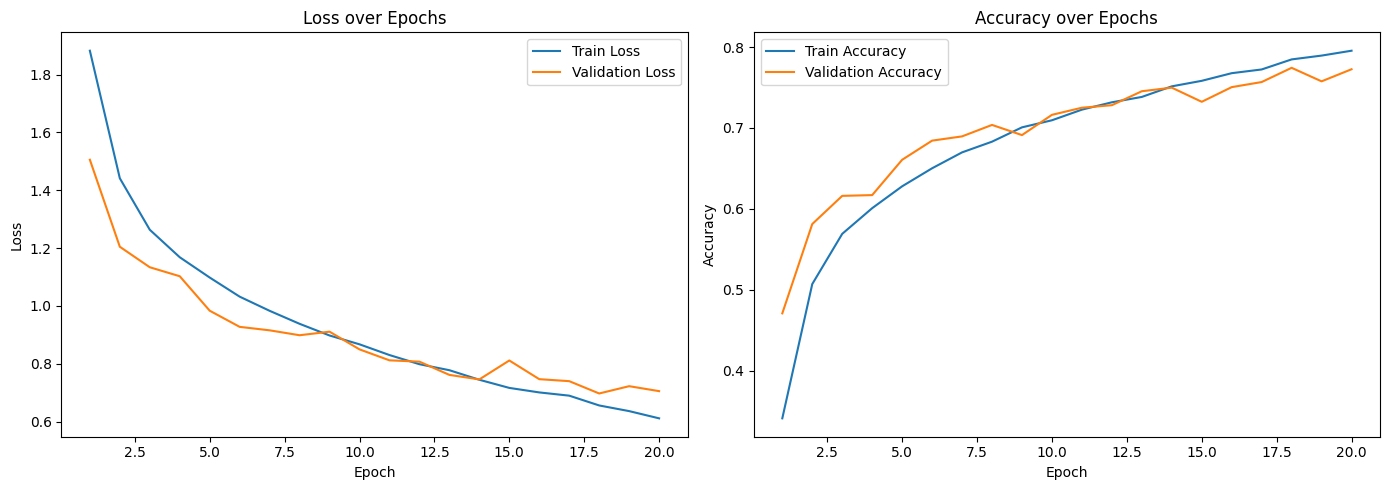

In [ ]:
train(model=model2, train_loader=train_loader, valid_loader=valid_loader)

In [ ]:
model = ConvNet()
model = ConvNet(input_shape=(3, 128, 128))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
print(model)

ConvNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3

In [ ]:
def train(model, train_loader, valid_loader, n_epochs=20, save_file='model1.pt'):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    epochs_no_improve = 0
    max_epochs_stop = 3
    valid_loss_min = np.inf

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0


        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim=1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end='\r')

        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                ps = torch.exp(output)
                topk, topclass = ps.topk(1, dim=1)
                equals = topclass == target.view(*topclass.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                valid_acc += accuracy.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_acc /= len(train_loader)
        valid_acc /= len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        print(f'Training Accuracy: {train_acc * 100:.2f}%\tValidation Accuracy: {valid_acc * 100:.2f}%')

        scheduler.step(valid_loss)

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_file)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early stopping triggered.')
                break


    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 1 	Training Loss: 2.399949 	Validation Loss: 2.170405
Training Accuracy: 17.49%	Validation Accuracy: 19.87%
Validation loss decreased (inf --> 2.170405). Saving model ...

Epoch: 2 	Training Loss: 2.142880 	Validation Loss: 2.030372
Training Accuracy: 22.24%	Validation Accuracy: 27.66%
Validation loss decreased (2.170405 --> 2.030372). Saving model ...

Epoch: 3 	Training Loss: 1.996219 	Validation Loss: 1.907265
Training Accuracy: 29.73%	Validation Accuracy: 31.13%
Validation loss decreased (2.030372 --> 1.907265). Saving model ...

Epoch: 4 	Training Loss: 1.894949 	Validation Loss: 1.744556
Training Accuracy: 34.04%	Validation Accuracy: 37.90%
Validation loss decreased (1.907265 --> 1.744556). Saving model ...

Epoch: 5 	Training Loss: 1.776611 	Validation Loss: 1.622143
Training Accuracy: 39.04%	Validation Accuracy: 44.16%
Validation loss decreased (1.744556 --> 1.622143). Saving model ...

Epoch: 6 	Training Loss: 1.663071 	Validation Loss: 1.490686
Training Accuracy: 42.9

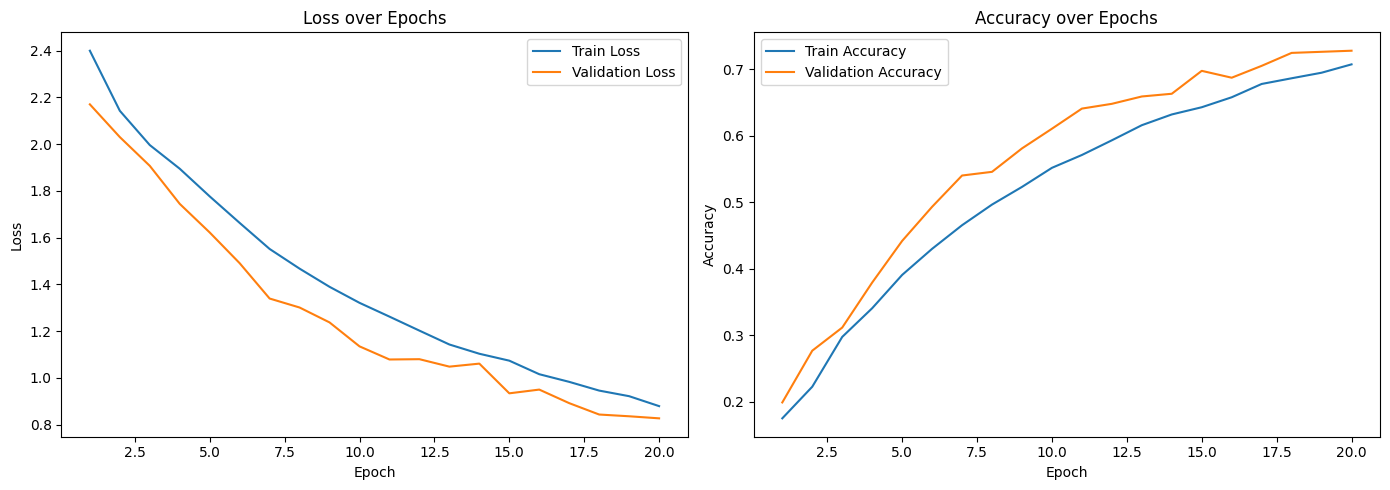

In [ ]:
train(model=model, train_loader=train_loader, valid_loader=valid_loader)

In [ ]:
criterion = nn.NLLLoss()
classes =  df.labels.unique()

In [ ]:
def evaluate(model, state_dict_file, test_loader, criterion, device, classes):
    model.load_state_dict(torch.load(state_dict_file))
    model.to(device)
    model.eval()

    test_loss = 0.0
    num_classes = len(classes)
    class_correct = torch.zeros(num_classes, dtype=torch.int32)
    class_total = torch.zeros(num_classes, dtype=torch.int32)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            correct = preds == target

            for i in range(data.size(0)):
                label = target[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss /= len(test_loader.dataset)
    print(f'\nTest Loss: {test_loss:.6f}\n')

    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100.0 * class_correct[i].item() / class_total[i].item()
            print(f'Test Accuracy of {classes[i]:>5s}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Test Accuracy of {classes[i]:>5s}: N/A (no test examples)')

    overall_acc = 100.0 * class_correct.sum().item() / class_total.sum().item()
    print(f'\nTest Accuracy (Overall): {overall_acc:.2f}% ({class_correct.sum()}/{class_total.sum()})')

evaluate(model, "model1.pt", test_loader, criterion, device, classes)


Test Loss: 0.815420

Test Accuracy of horse: 75.89% (321/423)
Test Accuracy of ragno: 45.65% (152/333)
Test Accuracy of sheep: 87.40% (541/619)
Test Accuracy of   cat: 34.58% (129/373)
Test Accuracy of chicken: 77.90% (758/973)
Test Accuracy of squirrel: 84.08% (243/289)
Test Accuracy of   cow: 67.05% (352/525)
Test Accuracy of elephant: 90.25% (870/964)
Test Accuracy of   dog: 71.70% (261/364)
Test Accuracy of butterfly: 64.88% (242/373)

Test Accuracy (Overall): 73.89% (3869/5236)


In [ ]:
criterion = nn.NLLLoss()
classes =  df.labels.unique()

In [ ]:
def evaluate(model, state_dict_file, test_loader, criterion, device, classes):
    model.load_state_dict(torch.load(state_dict_file))
    model.to(device)
    model.eval()

    test_loss = 0.0
    num_classes = len(classes)
    class_correct = torch.zeros(num_classes, dtype=torch.int32)
    class_total = torch.zeros(num_classes, dtype=torch.int32)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            correct = preds == target

            for i in range(data.size(0)):
                label = target[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss /= len(test_loader.dataset)
    print(f'\nTest Loss: {test_loss:.6f}\n')

    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100.0 * class_correct[i].item() / class_total[i].item()
            print(f'Test Accuracy of {classes[i]:>5s}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Test Accuracy of {classes[i]:>5s}: N/A (no test examples)')

    overall_acc = 100.0 * class_correct.sum().item() / class_total.sum().item()
    print(f'\nTest Accuracy (Overall): {overall_acc:.2f}% ({class_correct.sum()}/{class_total.sum()})')

evaluate(model2, "model1.pt", test_loader, criterion, device, classes)


Test Loss: 0.660608

Test Accuracy of   cow: 79.20% (335/423)
Test Accuracy of elephant: 55.56% (185/333)
Test Accuracy of sheep: 84.81% (525/619)
Test Accuracy of   cat: 63.81% (238/373)
Test Accuracy of chicken: 83.35% (811/973)
Test Accuracy of horse: 75.09% (217/289)
Test Accuracy of butterfly: 74.10% (389/525)
Test Accuracy of   dog: 93.05% (897/964)
Test Accuracy of ragno: 71.15% (259/364)
Test Accuracy of squirrel: 63.54% (237/373)

Test Accuracy (Overall): 78.17% (4093/5236)


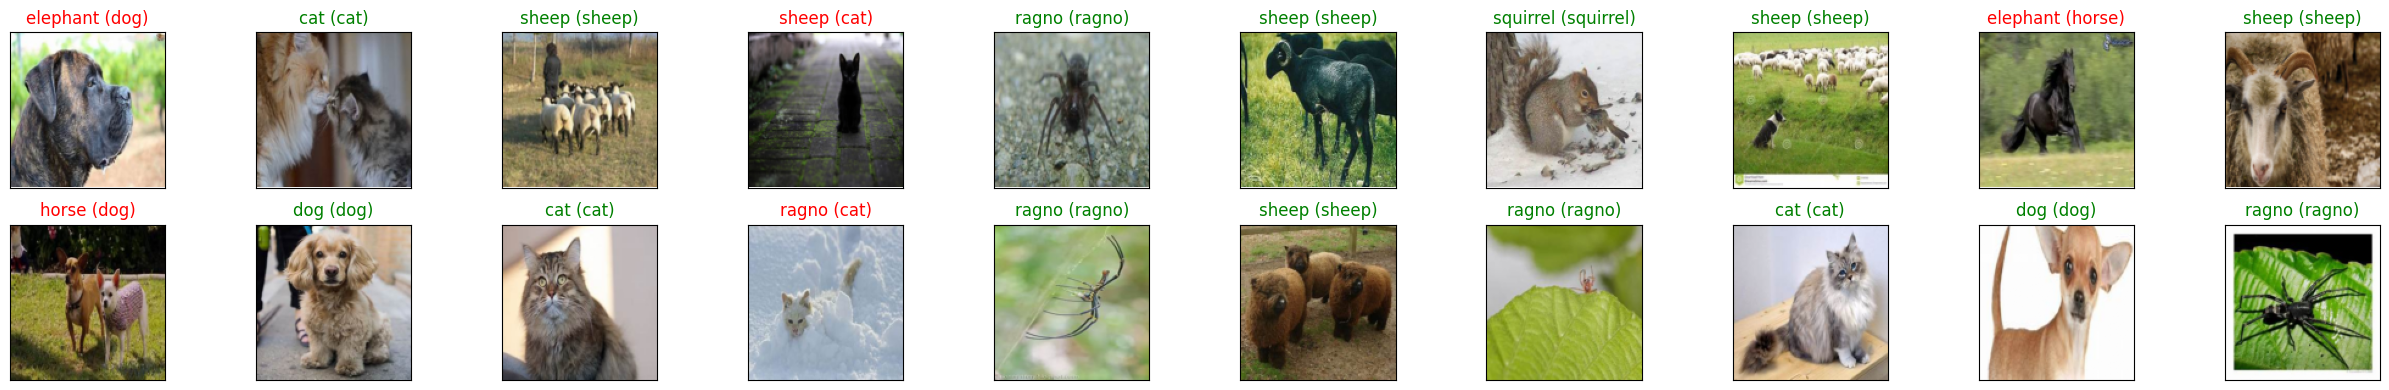

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds_tensor = torch.max(outputs, 1)

preds = preds_tensor.cpu().numpy()
labels = labels.cpu().numpy()
images = images.cpu()

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

fig = plt.figure(figsize=(25, 4))

def imshow(img):
    img = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    pred_label = idx_to_class[preds[idx]]
    true_label = idx_to_class[labels[idx]]
    ax.set_title(f"{pred_label} ({true_label})",
                 color=("green" if pred_label == true_label else "red"))

plt.tight_layout()
plt.show()

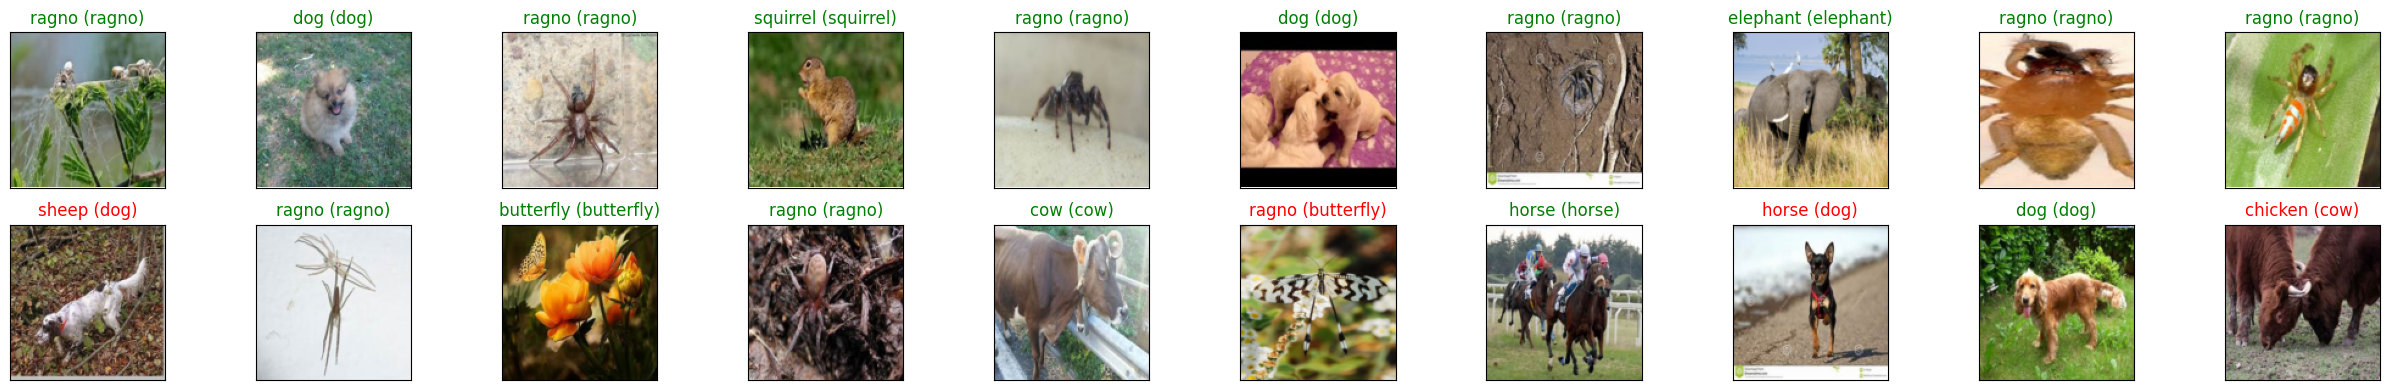

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

model2.eval()
with torch.no_grad():
    outputs = model2(images)
    _, preds_tensor = torch.max(outputs, 1)

preds = preds_tensor.cpu().numpy()
labels = labels.cpu().numpy()
images = images.cpu()

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

fig = plt.figure(figsize=(25, 4))

def imshow(img):
    img = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    pred_label = idx_to_class[preds[idx]]
    true_label = idx_to_class[labels[idx]]
    ax.set_title(f"{pred_label} ({true_label})",
                 color=("green" if pred_label == true_label else "red"))

plt.tight_layout()
plt.show()

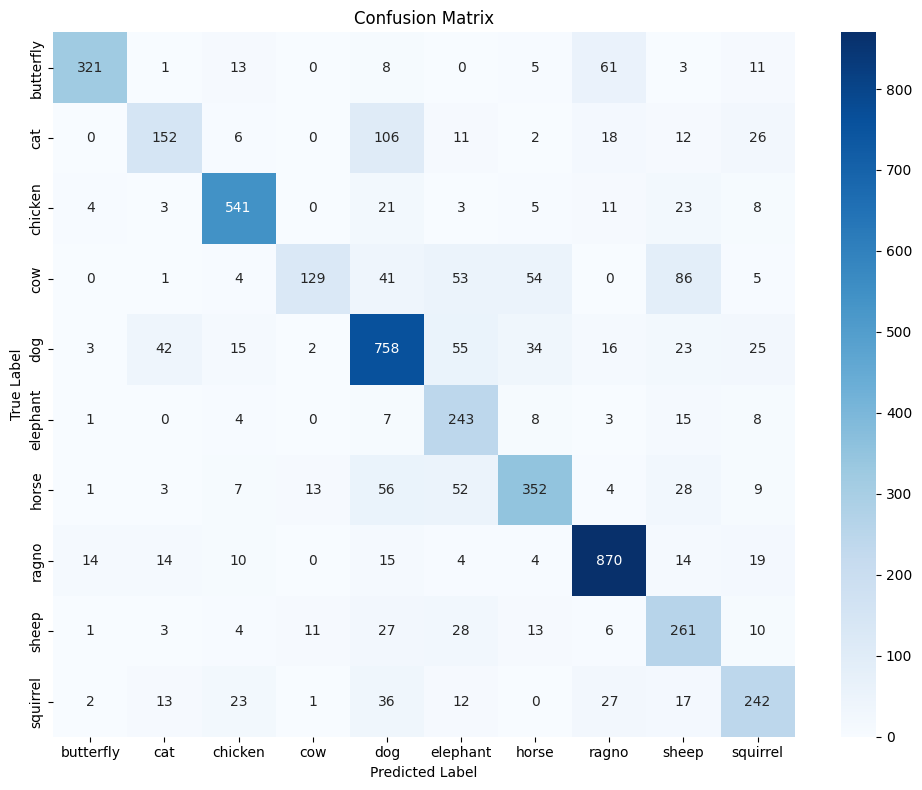

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

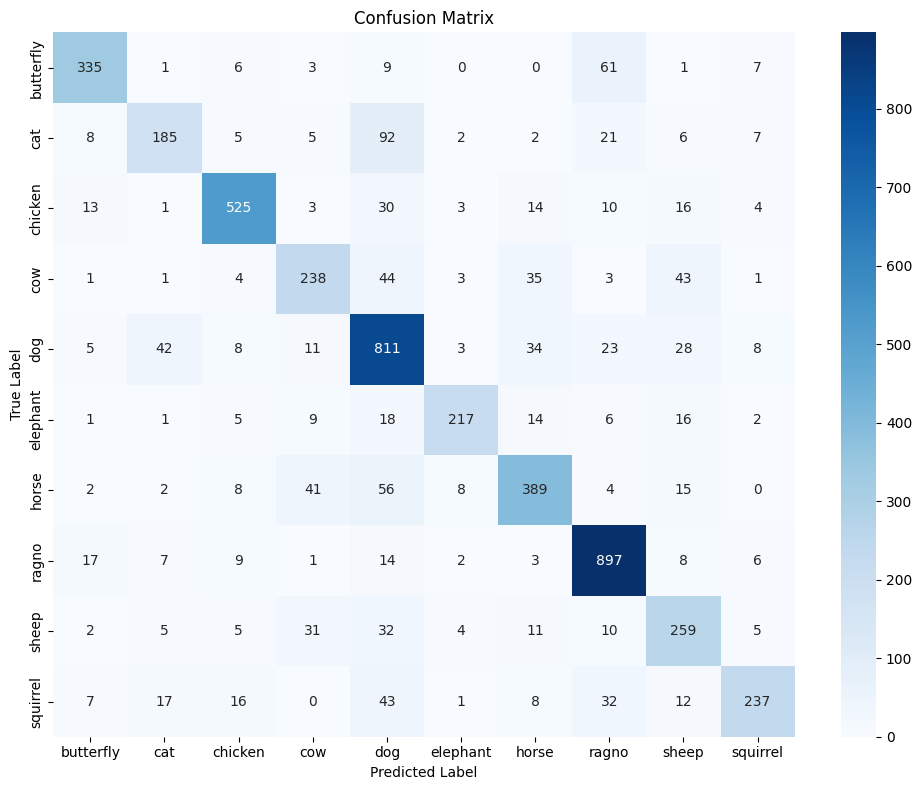

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = test_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

model2.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()